In [3]:
#basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
sns.set()
import os
import sys
import tomotopy as tp
import os
import re
import pyLDAvis
import seaborn as sns
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))
#print(os.walk('/kaggle/input'))

In [28]:
def normalize_scores(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    normalized_scores = (scores - min_score) / (max_score - min_score)
    return normalized_scores

def calculate_relevance(topic_term_dists, term_freqs, lambda_param=0.6):
    """Calculate relevance for each term in each topic."""
    topic_term_dists = np.array(topic_term_dists)
    term_freqs = np.array(term_freqs)
    term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies
    relevance = lambda_param * np.log(topic_term_dists) + (1 - lambda_param) * np.log(topic_term_dists / term_freqs)
    normalized_relevance = normalize_scores(relevance)
    return normalized_relevance

'''def calculate_saliency(topic_term_dists, term_freqs):
    """Calculate saliency for each term."""
    p_w = term_freqs / term_freqs.sum()
    saliency = (topic_term_dists * np.log(topic_term_dists / p_w)).sum(axis=0)
    return saliency'''
def calculate_saliency(topic_term_dists, term_freqs):
    term_freqs = np.array(term_freqs)
    term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies

    num_topics, num_terms = topic_term_dists.shape
    saliency = np.zeros_like(topic_term_dists)
    for k in range(num_topics):  # For each topic
        for w in range(num_terms):  # For each word in the vocabulary
            p_word_given_topic = topic_term_dists[k, w]
            p_word_in_corpus = term_freqs[w]
            saliency[k, w] += p_word_given_topic * np.log(p_word_given_topic / p_word_in_corpus)
    
    # for term_idx in range(num_terms):
    #     # p(t | w) is topic_term_dists[:, term_idx]
    #     p_t_given_w = topic_term_dists[:, term_idx]
        
    #     # p(t) is the overall topic distribution
    #     p_t = np.mean(topic_term_dists, axis=1)
        
    #     # Calculate saliency for the term
    #     saliency_term = np.sum(p_t_given_w * np.log(p_t_given_w / p_t)) * term_freqs[term_idx]
    #     saliency[term_idx] = saliency_term
    normalized_saliency = normalize_scores(saliency)
    return normalized_saliency


In [5]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    stop_words = set(["a", "an", "the", "and", "or", "but", "if", "on", "in", "to", "is", "of", "for"])
    words = [word for word in text.split() if len(word) > 2 and word not in stop_words]
    return words

In [29]:

def lda_example(file_paths, timestamps):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=15)#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    mdl.add_doc(words)
                    doc_timestamps.append(timestamp)
    mdl.burn_in = 500
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    mdl.summary()

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)
    for k in range(mdl.k):
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k)
        top_prob_words = [(word, prob) for word, prob in words_probs[:10]]

        relevance_scores = relevance[k]
        relevance_indices = np.argsort(relevance_scores)[::-1]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[idx]) for idx in relevance_indices[:10]]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:10]]

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [score for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words]
        relevance_values = [score for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [score for _, score in top_saliency_words]

        # Create DataFrame with words and scores for all three metrics
        combined_df = pd.DataFrame({
            'Probability Words': prob_words,
            'Relevance Words': relevance_words,
            'Saliency Words': saliency_words,
            'Probability Scores': prob_values,
            'Relevance Scores': relevance_values,
            'Saliency Scores': saliency_values
        })
        print(combined_df.to_string(index=False))
    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency,
        start_index=0, 
        sort_topics=False 
    )
    pyLDAvis.save_html(prepared_data, 'ldavis.html')
    # Aggregate topic distributions by time periods
    df = pd.DataFrame(doc_topic_dists, columns=[f'Topic_{i}' for i in range(mdl.k)])
    df['Timestamp'] = doc_timestamps
    
    # Calculate the average topic distribution for each time period
    topic_over_time = df.groupby('Timestamp').mean().reset_index()
    
    # Smooth out the frequency lines using a rolling average
    topic_over_time_smooth = topic_over_time.set_index('Timestamp').rolling(window=6, min_periods=1).mean().reset_index()
    
    # Plot the topic frequencies over time
    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns[1:]:
        plt.plot(topic_over_time_smooth['Timestamp'], topic_over_time_smooth[topic], label=topic)
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility
    df_melted = topic_over_time_smooth.melt(id_vars='Timestamp', var_name='Topic', value_name='Proportion')
    g = sns.FacetGrid(df_melted, col='Topic', col_wrap=4, sharey=False, height=3)
    g.map(sns.lineplot, 'Timestamp', 'Proportion')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels('Time Period', 'Average Topic Proportion')
    g.fig.suptitle('Topic Frequencies Over Time (Smoothed)', y=1.02)  # Title with better positioning
    g.add_legend()
    plt.tight_layout()
    plt.show()

In [7]:

def get_all_files_in_directory(directory):
    file_paths = []
    timestamps = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_paths.append(os.path.join(root, file))
                timestamp = os.path.basename(root)
                timestamps.append(timestamp)
    return file_paths, timestamps



In [8]:
# Path to the main directory containing subdirectories with text files
main_directory_path = './PSB_Papers/main_body'

print('Running LDA')

# Get all file paths in the main directory and its subdirectories
file_paths, timestamps = get_all_files_in_directory(main_directory_path)

Running LDA


Training...


Num docs: 349035 , Vocab size: 20287 , Num words: 2151360
Removed top words: ['gene', 'set', 'using', 'genes', 'number', 'used', 'two', 'one', 'protein', 'based', 'also', 'methods', 'sequence', 'network', 'expression']


Iteration: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s, LLPW: -8.828105]


<Basic Info>
| LDAModel (current version: 0.12.7)
| 349035 docs, 2151360 words
| Total Vocabs: 30729, Used Vocabs: 20287
| Entropy of words: 8.35542
| Entropy of term-weighted words: 8.35542
| Removed Vocabs: gene set using genes number used two one protein based also methods sequence network expression
|
<Training Info>
| Iterations: 100, Burn-in steps: 500
| Optimization Interval: 10
| Log-likelihood per word: -8.81869
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 15 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3124757907 (random seed)
| trained in version 0.

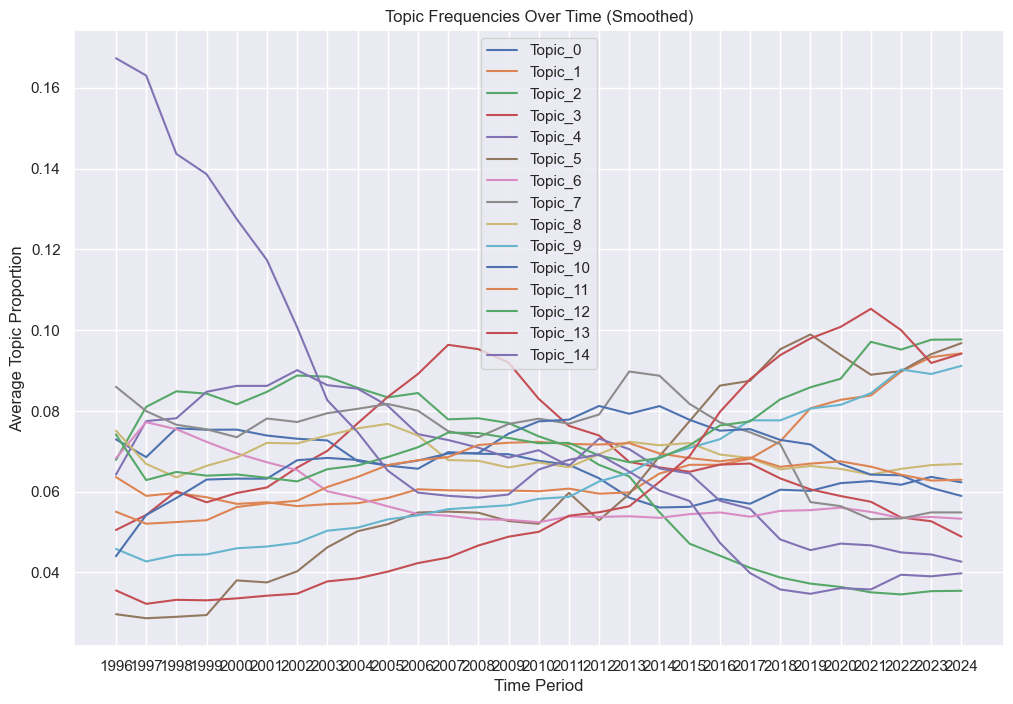

<Figure size 1400x1000 with 0 Axes>

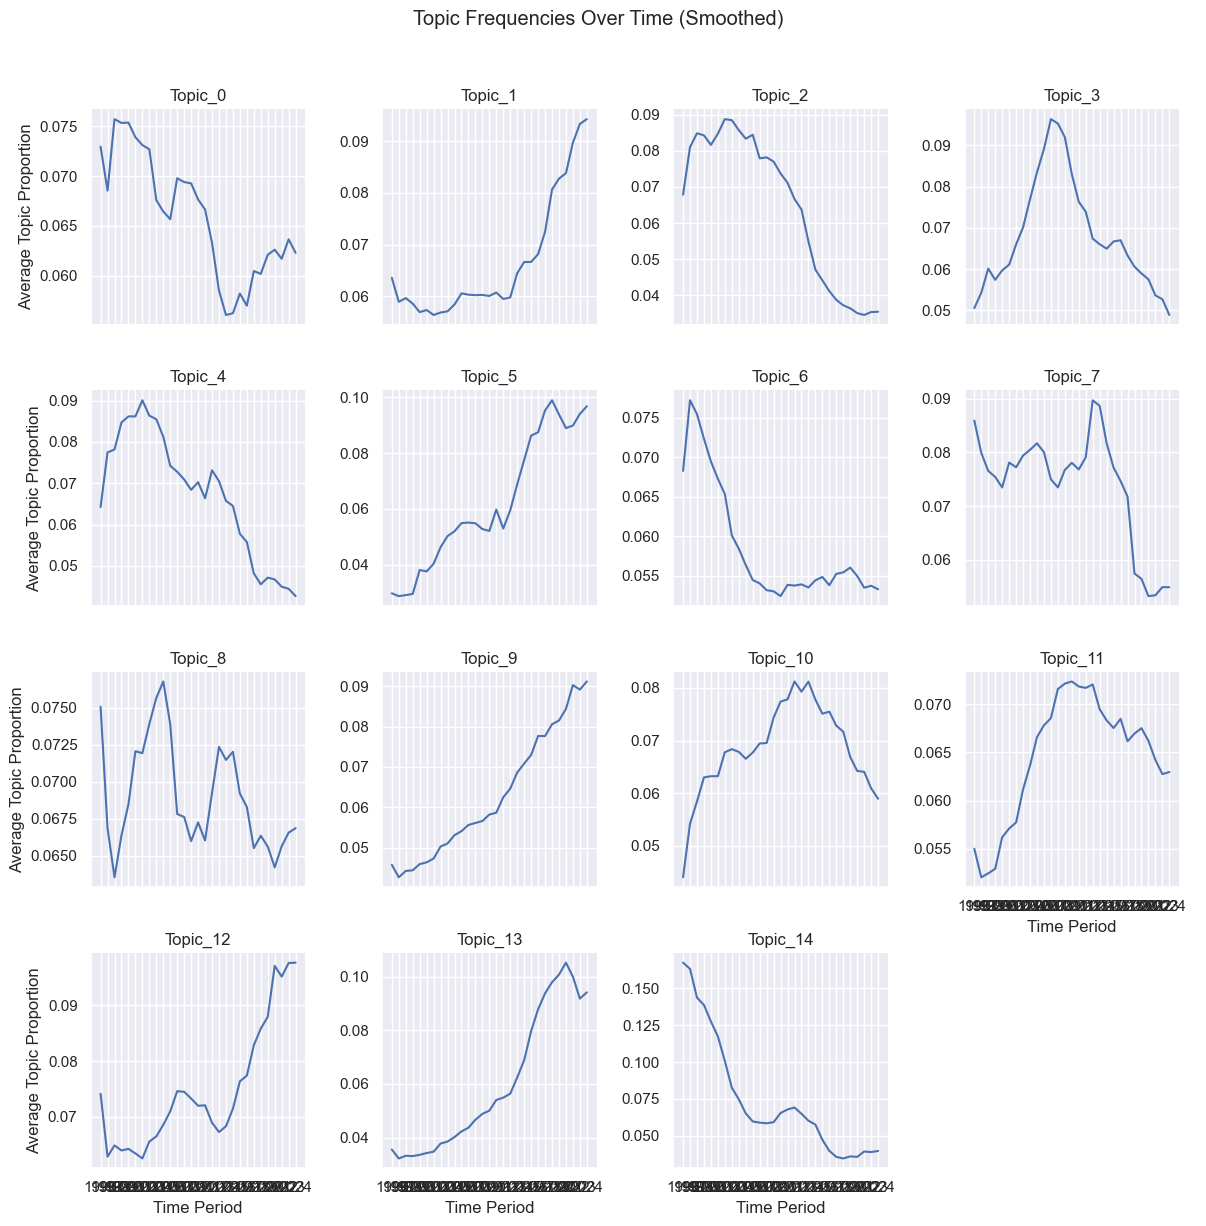

In [30]:
# Run the LDA model on all files
lda_example(file_paths, timestamps)

In [9]:
pip install sentence-transformers bertopic


  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
   ---------------------------------------- 0.0/227.1 kB ? eta -:--:--
   ---------------------------------------- 227.1/227.1 kB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/158.8 kB ? eta -:--:--
   ---------------------------------------- 158.8/158.8 kB 9.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/596.1 kB ? eta -:--:--
   --------------------------------------- 596.1/596.1 kB 18.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.4 MB 32.4 MB/s eta 0:00:01
   ----- ---------------------------------- 2.3/16.4 MB 29.0 MB/s eta 0:00:01
   -------- ------------------------------- 3.4/16.4 MB 27.2 MB/s eta 0:00:01
   ----------- ---------------------------- 4.5/16.4 MB 26.3 MB/s eta 0:00:01
   ------------- -------------------------- 5.5/16.4 MB 25.0 MB/s eta 0:00:01
   -------------- 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# BertTopic


In [ ]:

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

main_directory_path = '/kaggle/input/psb-conference-papers/main_body/'

print('get files')

file_paths, timestamps = get_all_files_in_directory(main_directory_path)


In [ ]:
#embeddings_loaded = np.load('/kaggle/input/psb-conference-papers/embeddings.npy')

In [ ]:
'''import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
def bert_topic_analysis(file_paths, timestamps, batch_size=10000):
    texts = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            processed_text = preprocess_text(text)
            texts.append(processed_text)

    texts = [item for sublist in texts for item in sublist] if any(isinstance(i, list) for i in texts) else texts
    
    model = SentenceTransformer('all-MiniLM-L6-v2')

    #embeddings = model.encode(texts, show_progress_bar=True)
    #np.save('embeddings.npy', embeddings)
    embeddings = embeddings_loaded
    timestamps = pd.to_datetime(timestamps, errors='coerce')
    topic_model = BERTopic()
    topics, probs = topic_model.fit_transform(texts,embeddings)


    df = pd.DataFrame({"Text": texts, "Timestamp": timestamps, "Topic": topics})

    topic_over_time = df.groupby(['Timestamp', 'Topic']).size().unstack(fill_value=0)
    topic_over_time = topic_over_time.div(topic_over_time.sum(axis=1), axis=0)

    topic_over_time = topic_over_time.sort_index()

    topic_over_time_smooth = topic_over_time.rolling(window=3, min_periods=1).mean()

    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns:
        plt.plot(topic_over_time_smooth.index, topic_over_time_smooth[topic], label=f'Topic {topic}')
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()

    topics_over_time_df = topic_model.topics_over_time(texts, timestamps)

    fig = topic_model.visualize_topics_over_time(topics_over_time_df)
    fig.show()

    for topic in set(all_topics):
        print(f"Topic {topic}:")
        topic_words = topic_model.get_topic(topic)[:]
        first_words = [word for word, _ in topic_words]  # Extract the first element of each tuple
        print(first_words)
        print("\n")

main_directory_path = '/kaggle/input/psb-conference-papers/main_body/'

print('Running BERTopic')

file_paths, timestamps = get_all_files_in_directory(main_directory_path)

bert_topic_analysis(file_paths, timestamps, batch_size=100)
'''